In [1]:
import json
import jsonlines
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from statistics import mean

In [2]:
FAIRNESS_LOTTERY = '../data/history_file_fairness_lottery_2agents.json'
LEAST_FAIR = '../data/history_file_least_fair_2agents.json'
MOST_COMPATIBLE = '../data/history_file_most_compatible_2agents.json'
PRODUCT_LOTTERY = '../data/history_file_product_lottery_2agents.json'
STATIC_LOTTERY = '../data/history_file_static_lottery_2agents.json'

recs_file = '../data/recs.csv'

In [3]:
recommender = pd.read_csv(recs_file, names=["User","Item","Score"])

In [4]:
history_files = [FAIRNESS_LOTTERY,LEAST_FAIR,MOST_COMPATIBLE,PRODUCT_LOTTERY,STATIC_LOTTERY]

fairness_lottery = []
least_fair = []
most_compatible = []
product_lottery = []
static_lottery = []

list_names = [fairness_lottery,least_fair,most_compatible,product_lottery,static_lottery]

In [5]:
for history_file, list_name in zip(history_files,list_names):
    with jsonlines.open(history_file) as reader:
        for obj in reader:
            list_name.append(obj)

In [6]:
results_fairness_lottery = {}
results_least_fair = {}
results_most_compatible = {}
results_product_lottery = {}
results_static_lottery = {}

dict_names = [results_fairness_lottery,results_least_fair,results_most_compatible,results_product_lottery,results_static_lottery]
readable_names = ["Fairness Lottery", "Least Fair", "Most Compatible", "Product Lottery", "Static Lottery"]

for list, dictionary in zip(list_names, dict_names):
    for line in list:
        results = line['choice_out']['results']
        results_list = []
        for item in results:
            results_list.append(item['item'])
        dictionary[line['user']] = results_list 


In [7]:
def librec_ndcg(scores1, scores2):
    idealDCG = 0.0
    recDCG = 0.0
    for index, val in enumerate(scores2): 
        idealDCG += (2**(len(scores2)-index) - 1)/np.log(index + 2)
    for index, val in enumerate(scores1):
        idealpos = scores2.index(val)
        recDCG += (2**(len(scores2)-idealpos) - 1)/np.log(index + 2)
    return recDCG/idealDCG

In [8]:
avg_of_ndcg = []
ndcg_results = {}
for dictionary, name in zip(dict_names, readable_names):
    users = []
    ndcg_values = []
    for user, items in dictionary.items():
        ideal_list = []
        sortedDF = recommender.loc[(recommender.User == int(user))].sort_values(by="Score",ascending=False)
        for item in sortedDF["Item"]:
            ideal_list.append(str(item))
        ndcg_values.append(librec_ndcg(items, ideal_list))
        users.append(user)
    avg_of_ndcg.append(mean(ndcg_values))
    ndcg_results[name] = {"Users":users, "NDCG":ndcg_values}

In [9]:
def plot_ndcg(name,ndcg_result):
    ndcg_result = ndcg_results[name]
    ndcg_data = pd.DataFrame(ndcg_result)
    sb.lineplot(ndcg_data)
    imagefile = name + "ndcgplot.png"
    plt.savefig(imagefile)

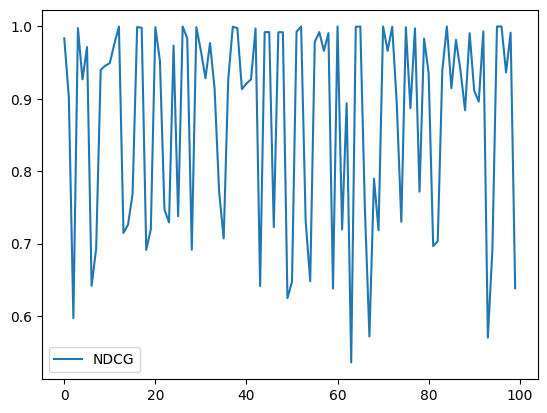

In [10]:
plot_ndcg("Fairness Lottery", ndcg_results)

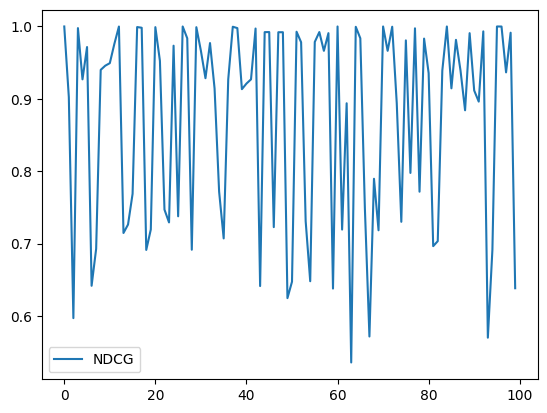

In [11]:
plot_ndcg("Least Fair", ndcg_results)

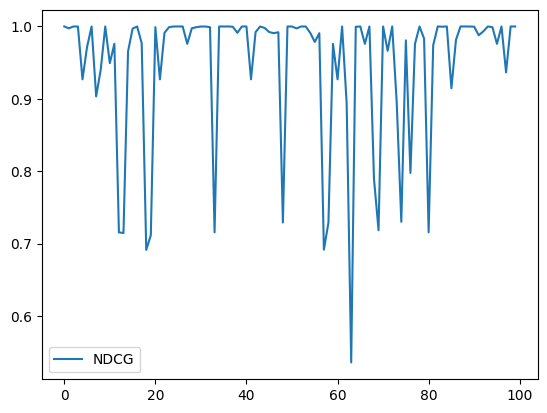

In [12]:
plot_ndcg("Most Compatible", ndcg_results)

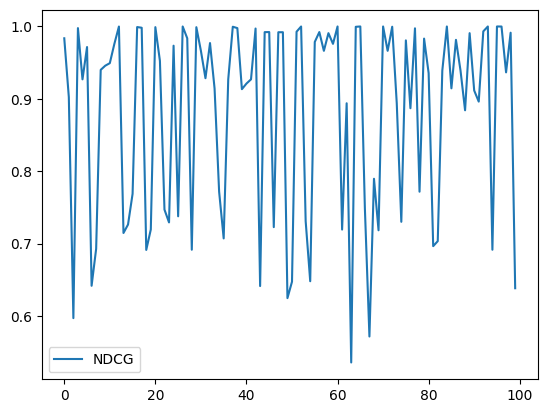

In [13]:
plot_ndcg("Product Lottery", ndcg_results)

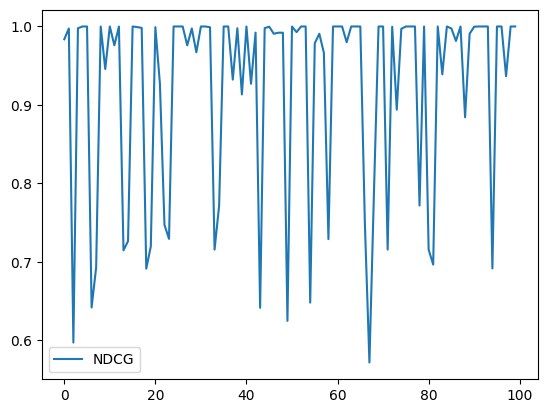

In [14]:
plot_ndcg("Static Lottery", ndcg_results)

In [15]:
ndcg_results = pd.DataFrame(data=avg_of_ndcg, index=readable_names, columns=["NDCG"])

In [16]:
ndcg_results

,NDCG
Fairness Lottery,0.872611
Least Fair,0.871316
Most Compatible,0.946505
Product Lottery,0.880113
Static Lottery,0.921147
